In [13]:
#Fetching data (reviews, rating stars, dates and countries) from https://www.airlinequality.com/airline-reviews/british-airways usinb BeautifulSoup


import requests
from bs4 import BeautifulSoup
import pandas as pd 

base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100
data = []

#loop through each page 
for i in range(1, pages + 1):
    # the URL collects links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    
    # it collect the html data from the webpage
    page = requests.get(url)

    #parse the content using BeautifulSoup
    soup = BeautifulSoup(page.content, "html.parser")
    reviews_on_page = soup.find_all("div", class_="text_content")
    stars_on_page = soup.find_all("div", class_="rating-10")
    dates_on_page = soup.find_all("time")
    countries_on_page = soup.find_all("h3")

    #loop through each review element and extract content 
    for j in range(len(reviews_on_page)):
        review = reviews_on_page[j].text.strip() if j < len(reviews_on_page) else "none"
        star = stars_on_page[j].span.text.strip() if j < len(stars_on_page) and stars_on_page[j].span else "none"
        date = dates_on_page[j].text.strip() if j < len(dates_on_page) else "none"
        country = (
            countries_on_page[j].span.next_sibling.text.strip("()").strip()
            if j < len(countries_on_page) and countries_on_page[j].span
            else "none"
        )

    # append the extracted data to a list 
    data.append({
    "Review": review,
    "Stars": star,
    "Date": date,
    "Country": country
    })

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data)


print(df.head())


                                              Review Stars  \
0  ✅ Trip Verified |  Flight left on time and arr...     8   
1  ✅ Trip Verified |  Ground and cabin crew alway...     1   
2  ✅ Trip Verified |  I wouldn't recommend Britis...     4   
3  ✅ Trip Verified |  Booked a BA holiday to Marr...     1   
4  ✅ Trip Verified |  As a seasoned traveller and...     9   

                 Date           Country  
0  29th December 2023  (United Kingdom)  
1    24th August 2023  (United Kingdom)  
2     15th April 2023  (United Kingdom)  
3  30th November 2022  (United Kingdom)  
4       1st June 2022  (United Kingdom)  


In [27]:
# DATA PROCESSING:
# Cleaning the reviews
# Tokenization
# POS tagging
# Stopwords removal
# Obtaining the stem words
# lemmatization 
#vectorise the reviews using TF-IDF


import pandas as pd
import re 
import nltk 
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# path to the CSV file containing the reviews
csv_file_path = 'reviews.csv'
#read the CSV file inro a panda dataframe
df = pd.read_csv(csv_file_path)

# CLEAN DATA 

#drop empty rows
df.dropna(subset=[df.columns[1]], inplace=True)


# Replace non-alphabet characters with a space
stop_words = set(stopwords.words('english'))

#function to clean the text
def clean(text):
     # Remove specific unwanted substrings
    text = re.sub(r'✅ Trip Verified+ \| ', '', text)
    text = re.sub(r'Not Verified \| ', '', text)
    text = re.sub(r'not verified', '', text)
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    text = text.lower()


    return text 

#Function to remove stop words
def remove_stop_words(tokens):
   return [word for word in tokens if word.lower() not in stop_words]

#Function to lemmatize tokens
# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
   return [lemmatizer.lemmatize(word) for word in tokens]

# Assuming the reviews column is the second column in the CSV
reviews_column = df.columns[1]

# Apply the clean function to the 'reviews' column
df['Cleaned Reviews'] = df[reviews_column].apply(clean)

# Tokenize the cleaned reviews
df['Tokenized Reviews'] = df['Cleaned Reviews'].apply(word_tokenize)

# Remove stop words from the tokenized reviews
df['No Stop Words Reviews'] = df['Tokenized Reviews'].apply(remove_stop_words)

# Lemmatize the tokens in the reviews without stop words
df['Lemmatized Reviews'] = df['No Stop Words Reviews'].apply(lemmatize_tokens)

# Perform POS tagging on the lemmatized reviews
df['POS Tagged Reviews'] = df['Lemmatized Reviews'].apply(pos_tag)

# Join the lemmatized tokens back into a single string for each review
df['Joined Lemmatized Reviews'] = df['Lemmatized Reviews'].apply(lambda tokens: ' '.join(tokens))

# Print the resulting DataFrame
print(df.head())


# Vectorize the reviews using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['Joined Lemmatized Reviews'])

# Print the TF-IDF feature names and the shape of the transformed data
print(tfidf_vectorizer.get_feature_names_out())
print(X.shape)



   Unnamed: 0                                             Review Stars  \
0           0  ✅ Trip Verified | If you can’t fly First Class...     5   
1           1  Not Verified |   Singapore to Heathrow. Busine...     1   
2           2  Not Verified |   I reported my damaged/ruined ...     1   
3           3  Not Verified |   On March 1st, I flew from Ber...     1   
4           4  Not Verified | The WORST customer experience! ...     1   

             Date           Country  \
0  19th July 2024   (United States)   
1  16th July 2024     (New Zealand)   
2  15th July 2024  (United Kingdom)   
3   9th July 2024         (Germany)   
4   5th July 2024  (United Kingdom)   

                                     Cleaned Reviews  \
0  if you can t fly first class don t fly british...   
1   singapore to heathrow business class on an a ...   
2   i reported my damaged ruined suitcase weeks a...   
3  not verified on march st i flew from berlin to...   
4  the worst customer experience british

In [90]:
df.dtypes

Unnamed: 0     int64
Review        object
Stars         object
Date          object
Country       object
dtype: object

In [92]:
# convert date to datetime format

from datetime import datetime, date

csv_file_path = 'reviews.csv'

def remove_ordinal_suffix(date_str):
    return re.sub(r'(\d+)(st|nd|rd|th)', r'\1', date_str)

df['Date'] = df['Date'].apply(remove_ordinal_suffix)
df['Date'] = pd.to_datetime(df['Date'], format='%d %B %Y', dayfirst=True)

print(df['Date'].head())

0   2024-07-19
1   2024-07-16
2   2024-07-15
3   2024-07-09
4   2024-07-05
Name: Date, dtype: datetime64[ns]


In [100]:
# cleaning stars rating and drop the rows where the value of rating is none 
df.Stars.unique()
df.drop(df[df.Stars == "none"].index, axis=0, inplace=True)

In [39]:
print("Unique values in 'Stars' column after filtering:", df.Stars.unique())

# Convert the 'Stars' column to numeric, if necessary (this will convert 'none' to NaN if still present)
df['Stars'] = pd.to_numeric(df['Stars'], errors='coerce')

# Calculate the average of the 'Stars' column
average_stars = df['Stars'].mean()

print("Average of 'Stars' column:", average_stars)

Unique values in 'Stars' column after filtering: ['5' '1' '6' '3' '9' '2' '8' '7' '4' '10' 'none']
Average of 'Stars' column: 4.601372605090077


In [118]:
cwd = os.getcwd()
df = pd.read_csv(cwd+"/cleaned_reviews.csv", index_col=8)

df = df.reset_index(drop=True)

In [120]:
df.head()

,Unnamed: 0,Review,Stars,Date,Country,Cleaned Reviews,Tokenized Reviews,No Stop Words Reviews,POS Tagged Reviews,Joined Lemmatized Reviews
0,0,✅ Trip Verified | If you can’t fly First Class...,5,19th July 2024,(United States),if you can t fly first class don t fly british...,"['if', 'you', 'can', 't', 'fly', 'first', 'cla...","['fly', 'first', 'class', 'fly', 'british', 'a...","[('fly', 'NN'), ('first', 'RB'), ('class', 'NN...",fly first class fly british airway uncomfortab...
1,1,Not Verified | Singapore to Heathrow. Busine...,1,16th July 2024,(New Zealand),singapore to heathrow business class on an a ...,"['singapore', 'to', 'heathrow', 'business', 'c...","['singapore', 'heathrow', 'business', 'class',...","[('singapore', 'RB'), ('heathrow', 'NN'), ('bu...",singapore heathrow business class premium econ...
2,2,Not Verified | I reported my damaged/ruined ...,1,15th July 2024,(United Kingdom),i reported my damaged ruined suitcase weeks a...,"['i', 'reported', 'my', 'damaged', 'ruined', '...","['reported', 'damaged', 'ruined', 'suitcase', ...","[('reported', 'VBN'), ('damaged', 'VBD'), ('ru...",reported damaged ruined suitcase week ago stil...
3,3,"Not Verified | On March 1st, I flew from Ber...",1,9th July 2024,(Germany),not verified on march st i flew from berlin to...,"['not', 'verified', 'on', 'march', 'st', 'i', ...","['verified', 'march', 'st', 'flew', 'berlin', ...","[('verified', 'VBN'), ('march', 'NN'), ('st', ...",verified march st flew berlin paulo ba encount...
4,4,Not Verified | The WORST customer experience! ...,1,5th July 2024,(United Kingdom),the worst customer experience british airways ...,"['the', 'worst', 'customer', 'experience', 'br...","['worst', 'customer', 'experience', 'british',...","[('worst', 'RB'), ('customer', 'NN'), ('experi...",worst customer experience british airway ba ef...


In [158]:
#Sentiment Analysis on the reviews (Joined Lemmatized reviews)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

# function to print sentiment of the reviews 
def sentimentanalysis(review):
    score = analyser.polarity_scores(review)  # corrected 'anayser' to 'analyser'
    return score['compound']  # corrected 'vs' to 'score'

# Assuming df is already defined and 'Joined Lemmatized Reviews' is a column in df
df['Sentiment'] = df['Joined Lemmatized Reviews'].apply(sentimentanalysis)

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['Analysis'] = df['Sentiment'].apply(vader_analysis)
df.head()




,Unnamed: 0,Review,Stars,Date,Country,Cleaned Reviews,Tokenized Reviews,No Stop Words Reviews,POS Tagged Reviews,Joined Lemmatized Reviews,Sentiment,Analysis
0,0,✅ Trip Verified | If you can’t fly First Class...,5,19th July 2024,(United States),if you can t fly first class don t fly british...,"['if', 'you', 'can', 't', 'fly', 'first', 'cla...","['fly', 'first', 'class', 'fly', 'british', 'a...","[('fly', 'NN'), ('first', 'RB'), ('class', 'NN...",fly first class fly british airway uncomfortab...,-0.9423,Negative
1,1,Not Verified | Singapore to Heathrow. Busine...,1,16th July 2024,(New Zealand),singapore to heathrow business class on an a ...,"['singapore', 'to', 'heathrow', 'business', 'c...","['singapore', 'heathrow', 'business', 'class',...","[('singapore', 'RB'), ('heathrow', 'NN'), ('bu...",singapore heathrow business class premium econ...,-0.0258,Negative
2,2,Not Verified | I reported my damaged/ruined ...,1,15th July 2024,(United Kingdom),i reported my damaged ruined suitcase weeks a...,"['i', 'reported', 'my', 'damaged', 'ruined', '...","['reported', 'damaged', 'ruined', 'suitcase', ...","[('reported', 'VBN'), ('damaged', 'VBD'), ('ru...",reported damaged ruined suitcase week ago stil...,-0.5994,Negative
3,3,"Not Verified | On March 1st, I flew from Ber...",1,9th July 2024,(Germany),not verified on march st i flew from berlin to...,"['not', 'verified', 'on', 'march', 'st', 'i', ...","['verified', 'march', 'st', 'flew', 'berlin', ...","[('verified', 'VBN'), ('march', 'NN'), ('st', ...",verified march st flew berlin paulo ba encount...,-0.9167,Negative
4,4,Not Verified | The WORST customer experience! ...,1,5th July 2024,(United Kingdom),the worst customer experience british airways ...,"['the', 'worst', 'customer', 'experience', 'br...","['worst', 'customer', 'experience', 'british',...","[('worst', 'RB'), ('customer', 'NN'), ('experi...",worst customer experience british airway ba ef...,-0.2263,Negative


In [174]:
sentiment_counts = df['Analysis'].value_counts()
sentiment_counts

Analysis
Positive    1694
Negative    1475
Neutral      331
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x1bcc7f39f40>,
 [Text(0.05526875904936967, 1.0986106518112515, 'Positive'),
  Text(-0.37446913283133954, -1.034298249324896, 'Negative'),
  Text(1.2908538240424647, -0.3952169087411949, 'Neutral')],
 [Text(0.030146595845110726, 0.599242173715228, '48.4%'),
  Text(-0.20425589063527608, -0.5641626814499432, '42.1%'),
  Text(0.8127598151378481, -0.24884027587408566, '9.5%')])

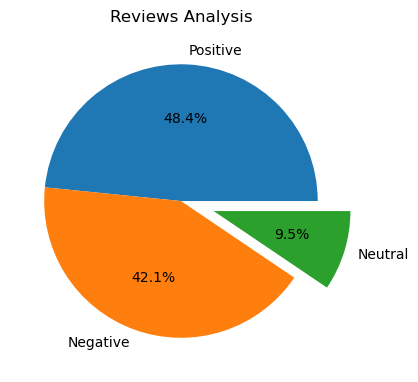

In [176]:
%matplotlib inline
plt.figure(figsize=(15,7))

plt.subplot(1,3,2)
plt.title("Reviews Analysis")
plt.pie(sentiment_counts.values, labels = sentiment_counts.index, explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

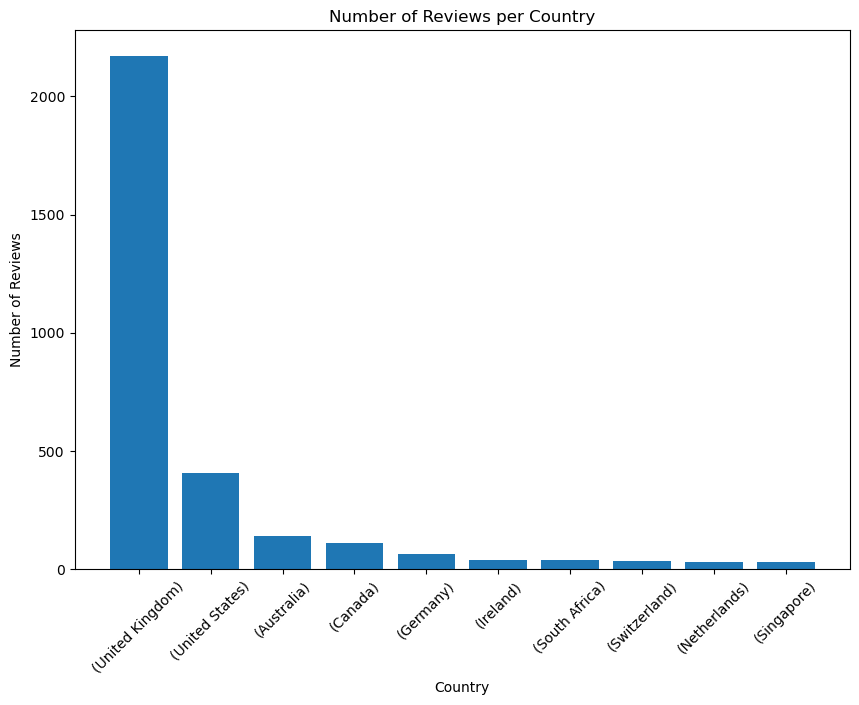

In [186]:
#calculated number of reviews per country 

import pandas as pd
from matplotlib import pyplot as plt

# Load the CSV file
csv_file_path = 'reviews.csv'
df = pd.read_csv(csv_file_path)

# Extract the Country column
country_column = df['Country']

# Count occurrences of each country
country_counts = country_column.value_counts()

# Figure Size
fig = plt.figure(figsize=(10, 7))

# Vertical Bar Plot
plt.bar(country_counts.index[:10], country_counts.values[:10])

# Labels and Title
plt.xlabel('Country')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Country')

# Show Plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()



In [45]:
# Load the CSV file
csv_file_path = 'cleaned_reviews.csv'
df = pd.read_csv(csv_file_path)

# Extract the rows where the Country is 'United Kingdom'
UK_reviews = df[df['Country'].str.contains('United Kingdom', na=False)]

# Select the relevant columns
UK_reviews = UK_reviews[['Country', 'Joined Lemmatized Reviews']]

# Preview the DataFrame
print(UK_reviews.head())




             Country                          Joined Lemmatized Reviews
2   (United Kingdom)  reported damaged ruined suitcase week ago stil...
4   (United Kingdom)  worst customer experience british airway ba ef...
6   (United Kingdom)  flight cancelled reason given le h departure e...
7   (United Kingdom)  route fly regularly used first class security ...
10  (United Kingdom)  four pleasant time flight friendly helpful sta...


In [47]:
#SENTIMENT ANALYSIS ON REVIEWS FROM UK TRAVELLERS 

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyser = SentimentIntensityAnalyzer()

# function to print sentiment of the reviews 
def sentimentanalysis(review):
    score = analyser.polarity_scores(review)  # corrected 'anayser' to 'analyser'
    return score['compound']  # corrected 'vs' to 'score'


# Apply sentiment analysis to the 'Joined Lemmatized Reviews' column
UK_reviews['Sentiment'] = UK_reviews['Joined Lemmatized Reviews'].apply(sentimentanalysis)

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment categorization to the sentiment scores
UK_reviews['Analysis_reviews'] = UK_reviews['Sentiment'].apply(vader_analysis)

print(UK_reviews.head())


             Country                          Joined Lemmatized Reviews  \
2   (United Kingdom)  reported damaged ruined suitcase week ago stil...   
4   (United Kingdom)  worst customer experience british airway ba ef...   
6   (United Kingdom)  flight cancelled reason given le h departure e...   
7   (United Kingdom)  route fly regularly used first class security ...   
10  (United Kingdom)  four pleasant time flight friendly helpful sta...   

    Sentiment Analysis_reviews  
2     -0.5994         Negative  
4     -0.2263         Negative  
6     -0.9657         Negative  
7      0.9524         Positive  
10     0.5759         Positive  


In [49]:
sentiment_counts = UK_reviews['Analysis_reviews'].value_counts()
sentiment_counts

Analysis_reviews
Positive    1234
Negative     707
Neutral      230
Name: count, dtype: int64

([<matplotlib.patches.Wedge at 0x195a6dcac90>,
 [Text(-0.2345640340695803, 1.0746998250306943, 'Positive'),
  Text(-0.12942959681384597, -1.092358905977612, 'Negative'),
  Text(1.2759155356705048, -0.4410663735025026, 'Neutral')],
 [Text(-0.12794401858340743, 0.5861999045621968, '56.8%'),
  Text(-0.07059796189846143, -0.5958321305332429, '32.6%'),
  Text(0.8033542261629103, -0.27770845739046457, '10.6%')])

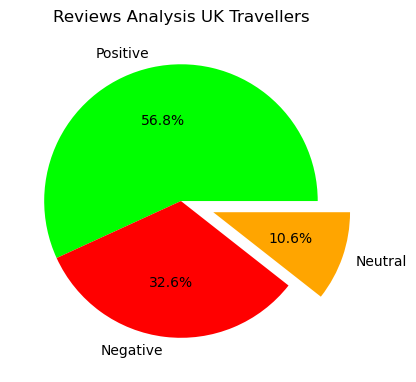

In [67]:
#PIE CHART ON SENTIMENT ANALYSIS DATA ONLY FROM UK TRAVELLERS 
from matplotlib import pyplot as plt
 
%matplotlib inline
plt.figure(figsize=(15,7))

plt.subplot(1,3,2)
plt.title("Reviews Analysis UK Travellers")

# Define custom colors
colors = ['#00FF00', '#FF0000', '#FFA500']

plt.pie(sentiment_counts.values, labels = sentiment_counts.index, explode = (0, 0, 0.25), colors=colors, autopct='%1.1f%%', shadow=False)

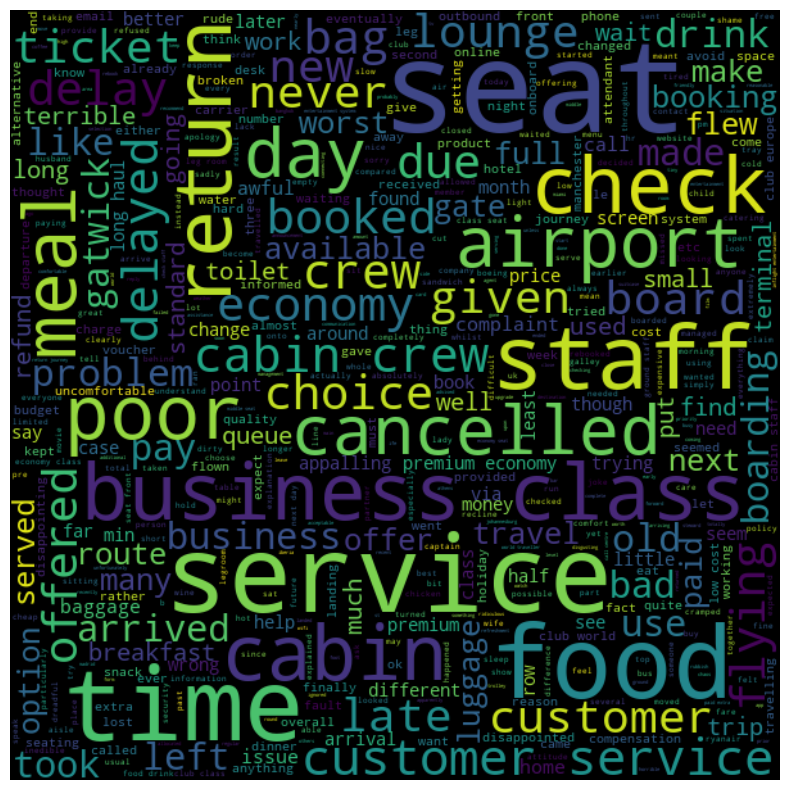

In [61]:
#WORDCLOUD ON NEGATIVE REVIEWS 

from wordcloud import WordCloud 
from nltk.corpus import stopwords
import matplotlib.pyplot as plt 


# Filter negative reviews
negative_reviews = UK_reviews[UK_reviews['Analysis_reviews'] == 'Negative']

# Concatenate all negative reviews into a single string
negative_reviews_wordcloud = " ".join(negative_reviews['Joined Lemmatized Reviews'].astype(str))

# Define stopwords
stop_words = set(stopwords.words('english'))
stop_words.update([
    "flight", "ba", "british", "airway", "airline", "passenger", "also", "got", "get", "verified", "fly", "told", "minute", "year", "good", "go", "last",  
    "asked", "nothing", "although", "despite", "take", "u", "review", "london", "however", 
    "heathrow", "aircraft", "could", "even", "would", "plane", "one", "althought", "still", "way", "hour", "people", "experience", "lhr", "back", "another", "first", "without", "really", "worse", "enough", "said", "first", "said", "two"
])

# Generate the word cloud

wordcloud = WordCloud(height=600, width=600, max_font_size=100, max_words=500, stopwords=stop_words).generate(negative_reviews_wordcloud)

plt.figure(figsize= (10,10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()
